In [51]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
import numpy as np
import matplotlib.pyplot as plt

import utils
import logistic_regression_gd

In [9]:
iris = datasets.load_iris()
X = iris.data[:, [2, 3]]
y = iris.target

print('Class labels:', np.unique(y))

# Datasets are already shuffled by sklearn
# Thanks to that otherwise all training data would be of the same classes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)
# stratification makes sure that both train and test sets have the same proportion of classes, e.g.:
print('Labels counts in y:', np.bincount(y))
print('Labels counts in y_train:', np.bincount(y_train))
print('Labels counts in y_test:', np.bincount(y_test))

Class labels: [0 1 2]
Labels counts in y: [50 50 50]
Labels counts in y_train: [35 35 35]
Labels counts in y_test: [15 15 15]


In [12]:
# Feature scale to make sure the data can be trained within the acceptable range of the model
sc = StandardScaler()
sc.fit(X_train)  # Estimates mean and std for each feature
X_train_std = sc.transform(X_train)  # Standardizes the features in training set
X_test_std = sc.transform(X_test)  # Uses same standardization for test set, to make sure they are comparable

In [31]:
# Train Perceptron model, this implementation internally uses One-vs.-Rest (OvR) strategy for multi-class classification
# eta0 is the learning rate
# random state guarantees reproducibility, by shuffling the data in the same way every epoch of training
ppn = Perceptron(eta0=0.1, random_state=1)
ppn.fit(X_train_std, y_train)

y_pred = ppn.predict(X_test_std)
print("Prediction", y_pred)
print("Expected  ", y_test)
print('Misclassified samples: %d' % (y_test != y_pred).sum())

classification_error = (y_test != y_pred).sum() / len(y_test) * 100
print("Classification error: %.2f%%" % classification_error)
print("scikit accuracy: %.3f" % accuracy_score(y_test, y_pred))
print("Model accuracy: %.3f" % ppn.score(X_test_std, y_test))

Prediction [2 0 0 2 1 1 2 1 2 0 0 2 0 1 0 1 2 1 1 2 2 0 1 2 1 1 0 2 0 2 0 0 1 1 2 2 0
 0 0 1 2 2 1 0 0]
Expected   [2 0 0 2 1 1 2 1 2 0 0 2 0 1 0 1 2 1 1 2 2 0 1 2 1 1 1 2 0 2 0 0 1 1 2 2 0
 0 0 1 2 2 1 0 0]
Misclassified samples: 1
Classification error: 2.22%
scikit accuracy: 0.978
Model accuracy: 0.978


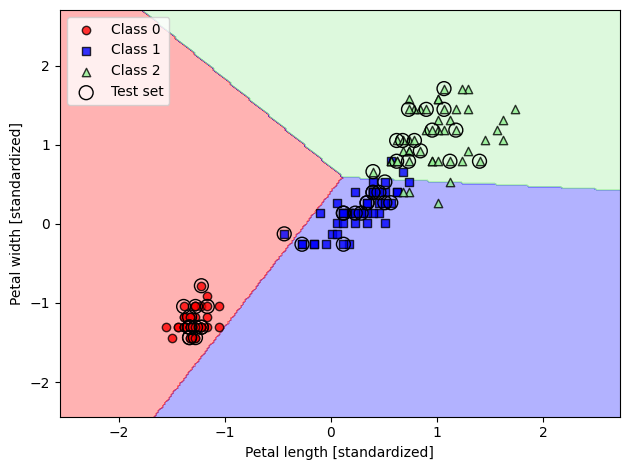

In [35]:
# Plot the model decision boundaries and data
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))
utils.plot_decision_regions(X=X_combined_std, y=y_combined, classifier=ppn, test_idx=range(105, 150))
plt.xlabel('Petal length [standardized]')
plt.ylabel('Petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In the plot below we can see that the Perceptron model is not able to classify the data correctly
because it cannot draw a linear decision boundary to separate the three classes perfectly.

# Logistic Regression

In logistic regression we want to assign a probability a given event belongs to a certain class given its input (features), denoted by 
$p := p(y=1|\vec{x})$, where $y=1$ is the positive class for the event, $\vec{x}$ is the feature vector, and $p$ is the probability of
that be true. If we define the probability $p$ by the logit function below, we have that given a probability in the range $[0,1]$, the 
logit function produces any real number.

\begin{equation}
$logit(p) = ln\frac{p}{1-p}$
\end{equation}

We can assume a linear relationship between the logit function real output produced with the input $p$ as below:

\begin{equation}
$logit(p) = w_1 x_1 + ... + w_m x_m + b = \vec{w}^T \vec{x} + b$
\end{equation}

Given we don't want to produce any real number from the linear combination of the input vector $\vec{x}$, but instead a probability between
$[0, 1]$ to assign the positive class, we can use the inverse of the logit function, also know as sigmoid function.

\begin{equation}
$\sigma(z) = \frac{1}{1 + e^{-z}}$
\end{equation}

and where $z$ is given by $z = \vec{w}^T \vec{x} + b$. You might have noticed that $z$ is very well know in neural networks as the input
of the activation function, which in this case is the sigmoid function.

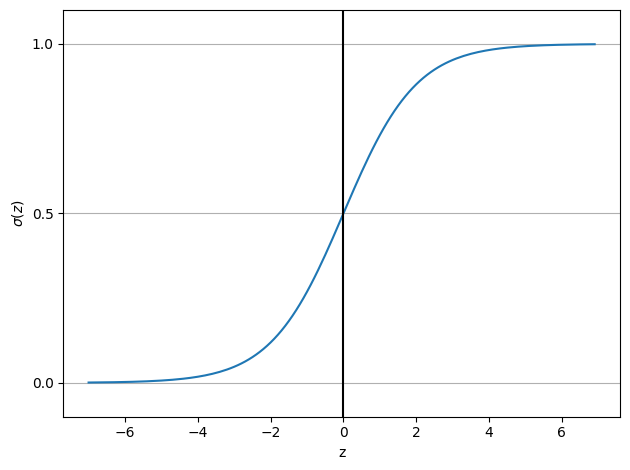

In [37]:
# Let's print the sigmoid function
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))


z = np.arange(-7, 7, 0.1)
sigma_z = sigmoid(z)

plt.plot(z, sigma_z)
plt.axvline(0.0, color='k')
plt.ylim(-0.1, 1.1)
plt.xlabel('z')
plt.ylabel('$\\sigma (z)$')
# y axis ticks and gridline
plt.yticks([0.0, 0.5, 1.0])
ax = plt.gca()
ax.yaxis.grid(True)
plt.tight_layout()
plt.show()

The output of the sigmoid function in the logistic regression model can be understood as the probability for an
event give by $\sigma(z) = p(y=1|\vec{x};\vec{w}, b)$. Now to discretize the output of the sigmoid function we can
use a threshold $\theta$ to classify the event as positive or negative, where $\theta = 0.5$ is the default threshold.

\begin{equation}
\hat{y} = \begin{cases}
1 \text{ if } \sigma(z) \geq \theta \\
0 \text{ otherwise}
\end{cases}
\end{equation}

Given the above as the forward pass of the network for prediction, we can define the loss function to be minimized and
train the model based on as the negative log-likelihood function.

\begin{equation}
L(\vec{w}, b) = -\sum_{i=1}^{n} [y^{(i)} log(\sigma(z^{(i)})) + (1 - y^{(i)}) log(1 - \sigma(z^{(i)}))]
\end{equation}

Which can also be interpreted as:

\begin{equation}
L(\sigma(z), y; \vec{w}, b) = \begin{cases}
-log(\sigma(z)) \text{ if } y = 1 \\
-log(1 - \sigma(z)) \text{ if } y = 0
\end{cases}
\end{equation}

Let's print below the loss function for different $z$ values:

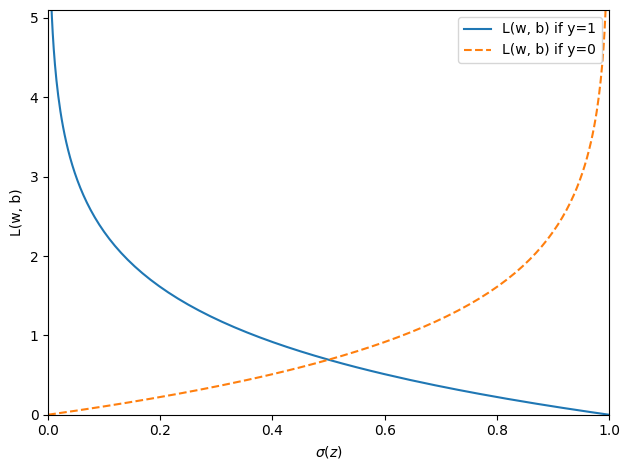

In [38]:
def loss_1(z):
    return - np.log(sigmoid(z))


def loss_0(z):
    return - np.log(1 - sigmoid(z))


z = np.arange(-10, 10, 0.1)
sigma_z = sigmoid(z)
c1 = [loss_1(x) for x in z]
plt.plot(sigma_z, c1, label='L(w, b) if y=1')
c0 = [loss_0(x) for x in z]
plt.plot(sigma_z, c0, linestyle='--', label='L(w, b) if y=0')
plt.ylim(0.0, 5.1)
plt.xlim([0, 1])
plt.xlabel('$\\sigma(z)$')
plt.ylabel('L(w, b)')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

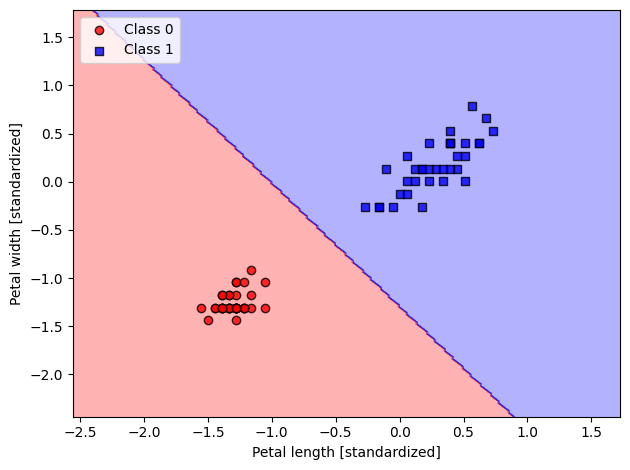

In [50]:
# Let's train a logistic regression model using the adapted Adaline model
# this only works for binary classification problems
X_train_01_subset = X_train_std[(y_train == 0) | (y_train == 1)]
y_train_01_subset = y_train[(y_train == 0) | (y_train == 1)]
lrgd = logistic_regression_gd.LogisticRegressionGD(eta=0.3, n_iter=1000, random_state=1)
lrgd.fit(X_train_01_subset, y_train_01_subset)

utils.plot_decision_regions(X=X_train_01_subset, y=y_train_01_subset, classifier=lrgd)
plt.xlabel('Petal length [standardized]')
plt.ylabel('Petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

# Logistic Regression with scikit-learn

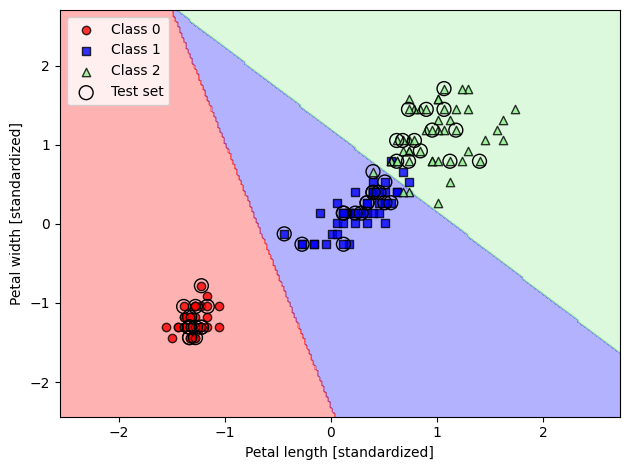

In [52]:
# C is the inverse regularization parameter, smaller values specify stronger regularization
lr = LogisticRegression(C=100.0, solver='lbfgs', multi_class='ovr', random_state=1)
lr.fit(X_train_std, y_train)

utils.plot_decision_regions(X_combined_std, y_combined, classifier=lr, test_idx=range(105, 150))
plt.xlabel('Petal length [standardized]')
plt.ylabel('Petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [69]:
# Checking each class probabilities for the first three examples.
# Each row represents the probabilities for sample, and each column represents on class
probs = lr.predict_proba(X_test_std[:3, :])
print("Probabilities:", probs)
print("Predicted class:", np.argmax(probs, axis=1))
print("Model label predictor:", lr.predict(X_test_std[:3, :]))

# If you want to predict a single example, you need to provide the model a 2D array
# this reshape converts a single row into a 2D array
single_sample = X_test_std[0, :].reshape(1, -1)
print("Single prediction:", lr.predict(single_sample))

Probabilities: [[6.63770505e-09 1.44747233e-01 8.55252760e-01]
 [8.34031210e-01 1.65968790e-01 3.20815954e-13]
 [8.48822884e-01 1.51177116e-01 2.57998350e-14]]
Predicted class: [2 0 0]
Model label predictor: [2 0 0]
Single prediction: [2]


# Overfitting

High Variance = Overfitting, the model is too complex and is fitting the noise in the data, not the underlying pattern.
High Bias = Underfitting, the model is too simple and cannot capture the underlying pattern in the data.

## Regularization

Regularization is a technique used to reduce the complexity of the model, by adding a penalty term to the loss function
to avoid overfitting. The most common regularization techniques are L1 and L2 regularization. L2 Regularization equation
to be added to the loss function is given by:

\begin{equation}
L2 = \frac{\lambda}{2n} \sum_{j=1}^{m} w_j^2
\end{equation}

As bigger the value of $\lambda$ more effect regularization has on training. Regularization is usually applied to the weights
and not the biases.

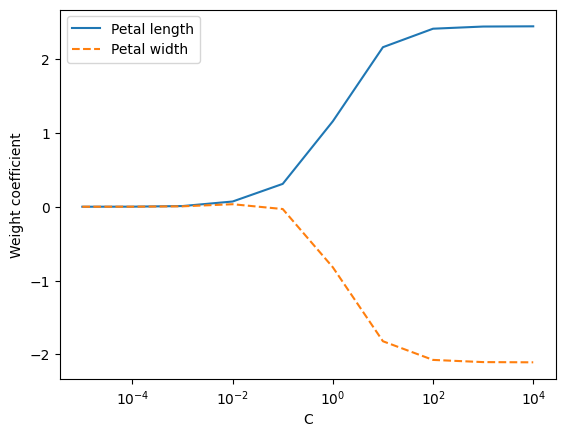

In [76]:
# Seeing the effect of regularization on the weights, notice that as C decreases the weights become smaller.
# Meaning, the regularization is more effective in reducing overfitting. Be careful with small values of C
# to avoid underfitting.
weights, params = [], []
for c in np.arange(-5, 5):
    lr = LogisticRegression(C=10.**c, multi_class='ovr')
    lr.fit(X_train_std, y_train)
    # Only weights for class 1 (Iris-Versicolor), for better illustration
    weights.append(lr.coef_[1])
    params.append(10.**c)

weights = np.array(weights)

plt.plot(params, weights[:, 0], label='Petal length')
plt.plot(params, weights[:, 1], linestyle='--', label='Petal width')
plt.ylabel('Weight coefficient')
plt.xlabel('C')
plt.legend(loc='upper left')
plt.xscale('log')
plt.show()